In [1]:
import sys
import os
os.chdir('/home/yash/Desktop/Decision-Flip-Experiments')
from scipy.misc import imread
import matplotlib.patches as mpatches
from models import *
from plotter import *
from saveloader import *
from fgsm_cifar import fgsm
from fgsm_cifar_wrt_class import fgsm_wrt_class
from helper import *
from helper import _to_categorical
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
sd = 'shape_dict'


def plot_all_data_graph(method,epochs,n,lyr):
    for from_cls in range(2):
        for to_cls in range(n_classes):
            if(from_cls != to_cls):
                l2_test, l2_train = restore_flip(method,epochs,n,from_cls,to_cls,lyr)
                #There might be a prob. here! since lens are diff, solved it inside the func
                plot_data_graph_without_random(l2_test, l2_train, n,from_cls,to_cls,lyr)
                plot_hists_without_random(l2_test, l2_train, n,from_cls,to_cls,lyr)
                


def make_data(n):
    X_test_sub = X_test[:n]
    X_train_sub = X_train[:n]
    y_train_sub = sess.run(env.ybar, feed_dict={env.x: X_train_sub,env.training: False})
    y_train_sub = _to_categorical(np.argmax(y_train_sub, axis=1), n_classes)
    y_test_sub = sess.run(env.ybar, feed_dict={env.x:X_test_sub ,env.training: False})
    y_test_sub = _to_categorical(np.argmax(y_test_sub, axis=1), n_classes)
    
    return X_test_sub, y_test_sub, X_train_sub, y_train_sub


def random_normal_func(X, n, save, lr, lrn):
    X=X.reshape(-1,img_rows*img_cols*img_chas)
    mean, std = np.mean(X, axis=0), np.std(X,axis=0)
    randomX = np.zeros([n,X[0].size])
    for i in range(X[0].size):
        randomX[:,i] = np.random.normal(mean[i],std[i],n)
    randomX = randomX.reshape(-1,img_rows,img_cols,img_chas)
    X_random_normal = randomX
    ans = sess.run(env.ybar, feed_dict={env.x: randomX,env.training: False})
    y_random_normal = _to_categorical(np.argmax(ans,axis=1), n_classes)
    X_random = np.random.rand(n,img_rows,img_cols,img_chas)
    y_random = sess.run(env.ybar, feed_dict={env.x: X_random,env.training: False})
    y_random = _to_categorical(np.argmax(y_random, axis=1), n_classes)
    
    if(save):
        save_as_txt(get_flip_path(lr),X_random)
        save_as_txt(get_flip_path(lrn),X_random_normal)
    
    return X_random, y_random, X_random_normal, y_random_normal  

def run_flip(method, epochs, n,from_cls=-1, to_cls = -1, layer= -1):
    save_obj({},sd)
    test_label = make_label("test", method, epochs,n, False)
    train_label = make_label("train", method, epochs,n, False)
    random_label = make_label("random", method, epochs,n, False)
    random_normal_label = make_label("random_normal", method, epochs,n, False)
#     data_label_random, data_label_random_normal = make_label("_", method, epochs,n, True)
    
    X_test_sub, y_test_sub, X_train_sub, y_train_sub = make_data(n)
#     X_random, y_random, X_random_normal, y_random_normal = restore_random_data(data_label_random, data_label_random_normal)
    
    if(method==2):
        X_flip_per_class_test = create_adv_wrt_class(X_test_sub, y_test_sub, test_label)
        X_flip_per_class_train = create_adv_wrt_class(X_train_sub, y_train_sub, train_label)
#         X_flip_per_class_random = create_adv_wrt_class(X_random, y_random, random_label)
#         X_flip_per_class_random_normal = create_adv_wrt_class(X_random_normal, y_random_normal, random_normal_label)
        
    if(from_cls != -1):
            print('From Class ' + str(from_cls) + '\n')
            X_test_sub, y_test_sub, X_flip_per_class_test = get_class(X_test_sub, y_test_sub,
                                                                      from_cls,X_flip_per_class_test)
            X_train_sub, y_train_sub, X_flip_per_class_train= get_class(X_train_sub, y_train_sub,
                                                                       from_cls,X_flip_per_class_train)
#             X_random, y_random, X_flip_per_class_random = get_class(X_random, y_random, 
#                                                                      from_cls, X_flip_per_class_random)
#             X_random_normal, y_random_normal, X_flip_per_class_random_normal = get_class(
#                 X_random_normal, y_random_normal,  from_cls, X_flip_per_class_random_normal)
            print('Test Data:' + str(y_test_sub.shape[0]))
            print('Train Data: ' + str(y_train_sub.shape[0]))
#             print('Random Data: ' + str(y_random.shape[0]))
#             print('Random Normal Data: ' + str(y_random_normal.shape[0]))
        
    _, X_flip_test = give_m2_ans(X_test_sub, X_flip_per_class_test, to_cls)
    _, X_flip_train = give_m2_ans(X_train_sub, X_flip_per_class_train, to_cls)
#     _, X_flip_random = give_m2_ans(X_random,X_flip_per_class_random, to_cls)
#     _, X_flip_random_normal = give_m2_ans(X_random_normal, X_flip_per_class_random_normal,to_cls)

    l2_test = get_l2_at_layer(X_flip_test,X_test_sub, layer)
    l2_train = get_l2_at_layer(X_flip_train, X_train_sub, layer)
#     l2_random = get_l2_at_layer(X_flip_random,X_random, layer)
#     l2_random_normal = get_l2_at_layer(X_flip_random_normal,X_random_normal, layer)

    return l2_test, l2_train

def restore_flip(method, epochs, n,from_cls=-1, to_cls = -1, layer= -1):
    test_label = make_label("test", method, epochs,n, False)
    train_label = make_label("train", method, epochs,n, False)
    random_label = make_label("random", method, epochs,n, False)
    random_normal_label = make_label("random_normal", method, epochs,n, False)
#     data_label_random, data_label_random_normal = make_label("_", method, epochs,n, True)
    
    X_test_sub, y_test_sub, X_train_sub, y_train_sub = make_data(n)
#     X_random, y_random, X_random_normal, y_random_normal = restore_random_data(data_label_random, data_label_random_normal)
    
    
    if(method==2):
        X_flip_per_class_test = load_from_txt(get_flip_path(test_label))
        X_flip_per_class_train = load_from_txt(get_flip_path(train_label))
#         X_flip_per_class_random = load_from_txt(get_flip_path(random_label))
#         X_flip_per_class_random_normal = load_from_txt(get_flip_path(random_normal_label))
            
        if(from_cls != -1):
            print('From Class ' + str(from_cls) + '\n')
            X_test_sub, y_test_sub, X_flip_per_class_test = get_class(X_test_sub, y_test_sub,
                                                                      from_cls,X_flip_per_class_test)
            X_train_sub, y_train_sub, X_flip_per_class_train= get_class(X_train_sub, y_train_sub,
                                                                        from_cls,X_flip_per_class_train)
#             X_random, y_random, X_flip_per_class_random = get_class(X_random, y_random, 
#                                                                      from_cls, X_flip_per_class_random)
#             X_random_normal, y_random_normal, X_flip_per_class_random_normal = get_class(
#                 X_random_normal, y_random_normal,  from_cls, X_flip_per_class_random_normal)
            print('Test Data:' + str(y_test_sub.shape[0]))
            print('Train Data: ' + str(y_train_sub.shape[0]))
#             print('Random Data: ' + str(y_random.shape[0]))
#             print('Random Normal Data: ' + str(y_random_normal.shape[0]))
            
    _, X_flip_test = give_m2_ans(X_test_sub, X_flip_per_class_test, to_cls)
    _, X_flip_train = give_m2_ans(X_train_sub, X_flip_per_class_train, to_cls)
#     _, X_flip_random = give_m2_ans(X_random,X_flip_per_class_random, to_cls)
#     _, X_flip_random_normal = give_m2_ans(X_random_normal, X_flip_per_class_random_normal,to_cls)

    l2_test = get_l2_at_layer(X_flip_test,X_test_sub, layer)
    l2_train = get_l2_at_layer(X_flip_train, X_train_sub, layer)
#     l2_random = get_l2_at_layer(X_flip_random,X_random, layer)
#     l2_random_normal = get_l2_at_layer(X_flip_random_normal,X_random_normal, layer)

    return l2_test, l2_train

def plot_data_graph(l2_test, l2_train, l2_random, l2_random_normal, n, from_cls, to_cls):
    %matplotlib inline
    t = np.arange(1,n+1, 1)
    plt.plot(t, l2_test[:n], 'r--', t, l2_train[:n],'b--', t, l2_random[:n], 'y--', l2_random_normal[:n], 'k--')
    blue_patch = mpatches.Patch(color='blue', label='Train Data')
    red_patch = mpatches.Patch(color='red', label='Test Data')
    yellow_patch = mpatches.Patch(color='yellow', label='Random Data')
    black_patch = mpatches.Patch(color='black', label='Random Normal Data')
    plt.legend(handles=[blue_patch, red_patch, yellow_patch, black_patch])
    plt.title("From " + str(from_cls) + " to " + str(to_cls))
    plt.xlabel("Examples")
    plt.ylabel("L2 Norm")
    
    plt.show()    

def plot_data_hist(l2,n,title):
    %matplotlib inline
    plt.hist(l2,n)
    plt.title(title)
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    
    plt.show()

def plot_hists_without_random(l2_test, l2_train, n,from_cls,to_cls,lyr):
    plot_data_hist(l2_test, l2_test.shape[0], "Train Data\n From " + str(from_cls) + " to " + str(to_cls) + " layer " + str(lyr))
    plot_data_hist(l2_train, l2_train.shape[0], "Test Data\n From " + str(from_cls) + " to " + str(to_cls)+ " layer " + str(lyr))
    
    
# one hot encoding, basically creates hte si
def _to_categorical(x, n_classes):
    x = np.array(x, dtype=int).ravel()
    n = x.shape[0]
    ret = np.zeros((n, n_classes))
    ret[np.arange(n), x] = 1
    return ret

def plot_data_graph_without_random(l2_test, l2_train, n, from_cls, to_cls,lyr):
    %matplotlib inline
    n = min(l2_test.shape[0], l2_train.shape[0])
    t = np.arange(1,n+1, 1)
    plt.plot(t, l2_test[:n], 'r--', t, l2_train[:n],'b--')
    blue_patch = mpatches.Patch(color='blue', label='Train Data')
    red_patch = mpatches.Patch(color='red', label='Test Data')
    yellow_patch = mpatches.Patch(color='yellow', label='Random Data')
    black_patch = mpatches.Patch(color='black', label='Random Normal Data')
    plt.legend(handles=[blue_patch, red_patch, yellow_patch, black_patch])
    plt.title("From " + str(from_cls) + " to " + str(to_cls)+ " layer " + str(lyr))
    plt.xlabel("Examples")
    plt.ylabel("L2 Norm")
    
    plt.show()    
    
    
    
def restore_random_data(lr, lrn):
    Xr = load_from_txt(get_flip_path(lr))
    Xrn = load_from_txt(get_flip_path(lrn))
    y_random_normal = sess.run(env.ybar, feed_dict={env.x: Xrn,env.training: False})
    y_random_normal = _to_categorical(np.argmax(y_random_normal,axis=1), n_classes)
    y_random = sess.run(env.ybar, feed_dict={env.x: Xr,env.training: False})
    y_random = _to_categorical(np.argmax(y_random, axis=1), n_classes)
    
    return Xr, y_random, Xrn, y_random_normal

/home/yash/Desktop/Decision-Flip-Experiments/plotter.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/ev

In [2]:
X_train, y_train, X_test, y_test, X_valid, y_valid = load_data(os)


Loading CIFAR10

Loading pre-Shuffled training data


In [3]:
class Dummy:
    pass
env = Dummy()

In [4]:
def model(x, logits=False, training=False, layer = -1):
    conv0 = tf.layers.conv2d(x, filters=32, kernel_size=[3, 3],
                             padding='same', name='conv0',
                             activation=tf.nn.relu)
    
    pool0 = tf.layers.max_pooling2d(conv0, pool_size=[2, 2],
                                    strides=2, name='pool0')
    
    conv1 = tf.layers.conv2d(pool0, filters=64,
                             kernel_size=[3, 3], padding='same',
                             name='conv1', activation=tf.nn.relu)
   
 
    
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=[2, 2],
                                    strides=2, name='pool1')
    
    conv2 = tf.layers.conv2d(pool1, filters=128,
                             kernel_size=[1,1], padding='same',
                             name='conv2', activation=tf.nn.relu)
    

    
    flat = tf.reshape(conv2, [-1, 8*8*128], name='flatten')
    
    dense1 = tf.layers.dense(flat, units= 1024, activation=tf.nn.relu,
                            name='dense1')
    
    dense2 = tf.layers.dense(dense1, units=128, activation=tf.nn.relu,
                            name='dense2')
    logits_ = tf.layers.dense(dense2, units=10, name='logits') #removed dropout
    
    y = tf.nn.softmax(logits_, name='ybar')
    
    
    if logits:
        return y, logits_
    
    y = tf.cond(tf.equal(layer, tf.constant(-1)), lambda: y, lambda: y)
    y = tf.cond(tf.equal(layer, tf.constant(0)), lambda: x, lambda: y)
    y = tf.cond(tf.equal(layer, tf.constant(1)), lambda: pool0, lambda: y)
    y = tf.cond(tf.equal(layer, tf.constant(2)), lambda: pool1, lambda: y)
    y = tf.cond(tf.equal(layer, tf.constant(3)), lambda: dense1, lambda: y)
    y = tf.cond(tf.equal(layer, tf.constant(4)), lambda: dense2, lambda: y)
    
    return y

In [5]:
# We need a scope since the inference graph will be reused later
with tf.variable_scope('model'):
    env.x = tf.placeholder(tf.float32, (None, img_rows, img_cols,
                                        img_chas), name='x')
    env.y = tf.placeholder(tf.float32, (None, n_classes), name='y')
    env.training = tf.placeholder(bool, (), name='mode')

    env.ybar, logits = model(env.x, logits=True,
                             training=env.training)
    
    z = tf.argmax(env.y, axis=1)
    zbar = tf.argmax(env.ybar, axis=1)
    env.count = tf.cast(tf.equal(z, zbar), tf.float32)
    env.acc = tf.reduce_mean(env.count, name='acc')

    xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y,
                                                   logits=logits)
    env.loss = tf.reduce_mean(xent, name='loss')

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(extra_update_ops):
    env.optim = tf.train.AdamOptimizer(beta1=0.9, beta2=0.999, epsilon=1e-08,).minimize(env.loss) 


In [6]:
with tf.variable_scope('model', reuse=True):
    env.lyr= tf.placeholder(tf.int32)
    env.layer_out = model(env.x, layer=env.lyr, logits=False ,training = env.training )

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [8]:
def save_model(label):
    saver = tf.train.Saver()
    saver.save(sess,  './models/cifar/' + label)
    
def restore_model(label):
    saver = tf.train.Saver()
    saver.restore(sess, './models/cifar/' + label)

In [9]:
def _evaluate(X_data, y_data, env):
    print('\nEvaluating')
    n_sample = X_data.shape[0]
    batch_size = 128
    n_batch = int(np.ceil(n_sample/batch_size))
    loss, acc = 0, 0
    ns = 0
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        batch_loss, batch_count, batch_acc = sess.run(
            [env.loss, env.count, env.acc],
            feed_dict={env.x: X_data[start:end],
                       env.y: y_data[start:end],
                       env.training: False})
        loss += batch_loss*batch_size
        print('batch count: {0}'.format(np.sum(batch_count)))
        ns+=batch_size
        acc += batch_acc*batch_size
    loss /= ns
    acc /= ns
#     print (ns)
#     print (n_sample)
    print(' loss: {0:.4f} acc: {1:.4f}'.format(loss, acc))
    return loss, acc

In [10]:
def _predict(X_data, env):
    print('\nPredicting')
    n_sample = X_data.shape[0]
    batch_size = 128
    n_batch = int(np.ceil(n_sample/batch_size))
    yval = np.empty((X_data.shape[0], n_classes))
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        batch_y = sess.run(env.ybar, feed_dict={
            env.x: X_data[start:end], env.training: False})
        yval[start:end] = batch_y
    return yval

def train(label):
    print('\nTraining')
    n_sample = X_train.shape[0]
    batch_size = 128
    n_batch = int(np.ceil(n_sample/batch_size))
    n_epoch = 50
    for epoch in range(n_epoch):
        print('Epoch {0}/{1}'.format(epoch+1, n_epoch))
        for ind in range(n_batch):
            print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
            start = ind*batch_size
            end = min(n_sample, start+batch_size)
            sess.run(env.optim, feed_dict={env.x: X_train[start:end],
                                           env.y: y_train[start:end],
                                           env.training: True})
        if(epoch%5 == 0):
            model_label = label+ '{0}'.format(epoch)
            print("saving model " + model_label)
            save_model(model_label)
            
    save_model(label)

def train_again(X, y, epochs):
    #Not making batches, do that if size > 128
    for i in range(X.shape[0]):
        for e in range(epochs):
            sess.run(env.optim, feed_dict={env.x: [X[i]],
                                           env.y: [y[i]],
                                           env.training: True})
            
    
    

In [11]:
def create_adv_wrt_class(X, Y, label = None):
    print('\nCrafting adversarial')
    n_sample = X.shape[0]
    pred = np.argmax(Y,axis=1)
    batch_size = 1
    n_batch = int(np.ceil(n_sample/batch_size))
    n_epoch = 20
    x_adv_shape = list(X.shape)[1:]
    x_adv_shape = np.append(np.append(n_sample,n_classes),x_adv_shape)
    X_adv = np.empty(x_adv_shape)
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        tmp = sess.run(env.x_adv_wrt_class, feed_dict={env.x: X[start:end],
                                             env.y: Y[start:end],
                                             env.training: False})
        tmp[pred[start]] = X[start]
        X_adv[start:end] = tmp
    if(label != None):
        print('\nSaving adversarial')
        os.makedirs('data', exist_ok=True)
        save_as_txt(get_flip_path(label), X_adv)
    return X_adv

In [12]:
def create_adv(X, Y, label):
    print('\nCrafting adversarial')
    n_sample = X.shape[0]
    batch_size = 1
    n_batch = int(np.ceil(n_sample/batch_size))
    n_epoch = 20
    X_adv = np.empty_like(X)
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        tmp, all_flipped = sess.run([env.x_adv, env.all_flipped], feed_dict={env.x: X[start:end],
                                             env.y: Y[start:end],
                                             env.training: False})
        X_adv[start:end] = tmp
    print('\nSaving adversarial')
    os.makedirs('data', exist_ok=True)
    save_as_txt(get_flip_path(label), X_adv)
    return X_adv

In [13]:
method = 2
n = 1000
epochs = 200
label="cifar_with_cnn"
lyrs= 4

# train(label)
restore_model(label + str(epochs))
# _evaluate(X_train, y_train, env)

INFO:tensorflow:Restoring parameters from ./models/cifar/cifar_with_cnn200


In [14]:


# train_label = make_label("train", method, epochs,n, False)
# n_exs = 15 
# X = X_test[:n_exs]
# X_flip =  load_from_txt(get_flip_path(train_label))
# X_flip = X_flip[:n_exs]





# for i in range(lyrs):
#     plot_all_data_graph(method,epochs,n,i)


In [15]:
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec

# gs = gridspec.GridSpec(2, 2)


# ax1 = plt.subplot(gs[0,0])
# ax1.plot([1,2,3],[1,2,3])
# ax2 = plt.subplot(gs[0,1])
# ax3 = plt.subplot(gs[1, 0])
# ax4 = plt.subplot(gs[1,1])

# fig = plt.gcf()
# fig.set_size_inches(20, 10.5)
# plt.savefig('test.png', dpi=80)

In [16]:
# import numpy as np
# a = np.array([[3,4],[5,6]])
# b = np.array([1,2])
# d = np.array([5,6])
# c = [a,b]
# np.sum(a,axis=0)/len(a)

In [17]:
def get_centroids(X,Xs,n=None):
    if n is not None:
        X = X[:n]
    ys = _predict(Xs,env)
    y = _predict(X,env)
    y_ = np.argmax(y, axis=1)
    X_centroids = np.empty([n_classes, img_rows, img_cols, img_chas])
    for c in range(n_classes):
        Xt,yt = get_class(Xs,ys,c)
        print(len(Xt))
        X_centroids[c] = np.sum(Xt, axis =0 )/len(Xt)
    ans = np.empty_like(X)
    for i in range(len(X)):
        ans[i] = X_centroids[y_[i]]
    return ans    
    
def get_class(X, Y, cls, Z=None):
    p = np.argmax(Y, axis=1)
    indices = np.where(p == cls)
    if Z is not None:
        return X[indices], Y[indices], Z[indices]
    else:
        return X[indices], Y[indices]

In [18]:
#Using X_own as the centroid of the class
def func(X,X_flip):
    l2_flip = np.empty([n_exs,lyrs], dtype = np.float32)
    l2_own_cls = np.empty([n_exs,lyrs], dtype = np.float32)
    X_own = get_centroids(X,X_test[3000:4000])
    
    _, X_flip_min = give_m2_ans(X,X_flip)
#     print(X_flip_min.shape)
#     print(X_own.shape)
    for lyr in range(lyrs):
        l2_flip[:,lyr] = get_l2_at_layer(X,X_flip_min,sess, env,lyr)
        l2_own_cls[:,lyr] = get_l2_at_layer(X,X_own,sess, env,lyr)
    
    return l2_flip, l2_own_cls



In [19]:
method = 2
n = 1000
epochs = 200
label="cifar_with_cnn"
lyrs= 4
train_label = make_label("train", method, epochs,n, False)
n_exs = 100
X = X_train[:n_exs]
X_flip =  load_from_txt(get_flip_path(train_label))
X_flip = X_flip[:n_exs]

In [20]:
ans = func(X,X_flip)



Predicting
 batch 8/8
Predicting
97atch 1/1
95
99
83
115
101
100
99
96
115


In [21]:
# print(ans[0][0])
# print(ans[1][0])

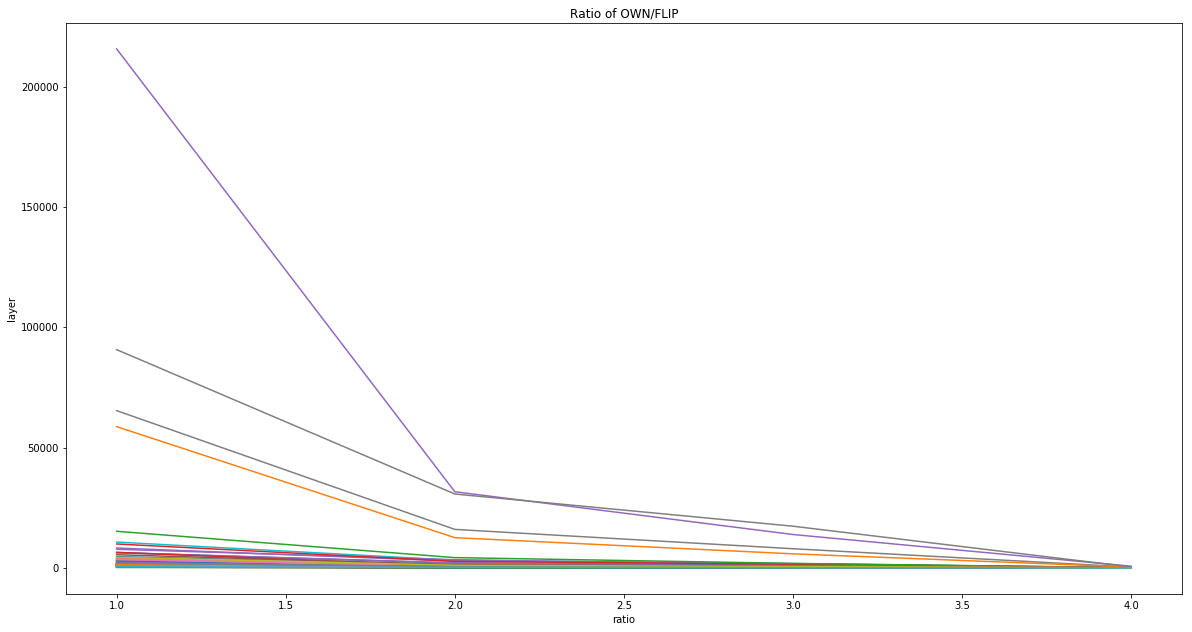

In [27]:
import matplotlib.pyplot as plt

k=ans[1]/ans[0]
for i in range(len(k)):
    plt.plot([1,2,3,4],k[i])
fig = plt.gcf()
fig.set_size_inches(20, 10.5)
plt.title("Ratio of OWN/FLIP")
plt.xlabel("ratio")
plt.ylabel("layer")
plt.show()